In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
import pandas as pd
import os
import json
import glob

def sync_json_to_excel(data_dir="../data/", excel_filename="workout_log.xlsx"):
    excel_path = os.path.join(data_dir, excel_filename)
    
    # 1. Load existing data and standardize timestamps to strings
    existing_timestamps = set()
    if os.path.exists(excel_path):
        df_existing = pd.read_excel(excel_path)
        if not df_existing.empty:
            # Force everything to string and strip any trailing .0 or seconds
            existing_timestamps = set(df_existing['Timestamp'].astype(str).str.strip().unique())
            print(f"Loaded {len(existing_timestamps)} existing sessions from Excel.")
    else:
        print("Excel log not found. Starting a fresh file.")
        df_existing = pd.DataFrame()

    # 2. Iterate through all JSON files
    new_records = []
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    
    print(f"Found {len(json_files)} JSON files in {data_dir}.")

    for file in json_files:
        with open(file, 'r') as f:
            try:
                session_data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error: Could not decode {file}. Skipping.")
                continue
            
            if session_data:
                # Standardize JSON timestamp to string for comparison
                session_ts = str(session_data[0].get("Timestamp")).strip()
                
                if session_ts not in existing_timestamps:
                    new_records.extend(session_data)
                    print(f"Adding new session: {session_ts}")
                    # Add to set to prevent duplicates if two JSONs have same TS
                    existing_timestamps.add(session_ts)
                else:
                    print(f"Skipping already logged session: {session_ts}")

    # 3. Append and Save
    if new_records:
        df_new = pd.DataFrame(new_records)
        
        # Calculate e1RM for the new records before appending
        if 'Load_kg' in df_new.columns and 'Reps' in df_new.columns:
            df_new['e1RM'] = df_new['Load_kg'] * (1 + df_new['Reps'] / 30)

        df_final = pd.concat([df_existing, df_new], ignore_index=True)
        
        # Ensure 'Timestamp' is the first column for scannability
        cols = ['Timestamp'] + [c for c in df_final.columns if c != 'Timestamp']
        df_final = df_final[cols]
        
        df_final.to_excel(excel_path, index=False)
        print(f"SUCCESS: {len(new_records)} sets written to {excel_path}.")
    else:
        print("No new data was identified for syncing.")

# Call the function
sync_json_to_excel()

Found 1 JSON files in ../data/.
Adding new session: 2026-01-25 10:00:00
SUCCESS: 19 sets written to ../data/workout_log.xlsx.


In [7]:
# Load the data
file_path = "../data/workout_log.xlsx"
df = pd.read_excel(file_path)

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date

# Comprehensive Movement Family Mapping
FAMILY_MAP = {
    "Front Squat": "Squat", "Back Squat": "Squat", "Zercher Squat": "Squat",
    "Deadlift": "Hinge", "Zercher Deadlift": "Hinge", "Romanian Deadlift": "Hinge", 
    "Kettlebell Swings": "Hinge",
    "Barbell Bench Press": "Push (H)", "Incline BB Press": "Push (H)", "DB Press": "Push (H)",
    "Incline DB Press": "Push (H)", "Incline DB Fly": "Push (H)", "Dips": "Push (H)", 
    "Dumbbell Pullover": "Push (H)",
    "Standing OHP": "Push (V)", "Overhead Press": "Push (V)", "DB Shoulder Press": "Push (V)",
    "Bent over Barbell Rows": "Pull (H)", "Cable Rows": "Pull (H)",
    "Pull Ups": "Pull (V)", "Lat Pulldown": "Pull (V)",
    "Incline Bicep Curl": "Isolation", "Barbell Bicep Curl": "Isolation", 
    "Cable Bicep Curl": "Isolation", "Cable Tricep Pushdown": "Isolation",
    "Cable Crunches": "Core"
}

# Apply Mapping and Calculate e1RM
df['Family'] = df['Movement'].map(FAMILY_MAP).fillna("Other")
df['e1RM'] = df['Load_kg'] * (1 + df['Reps'] / 30)

print(f"Loaded {len(df)} sets across {df['Date'].nunique()} sessions.")

Loaded 19 sets across 1 sessions.


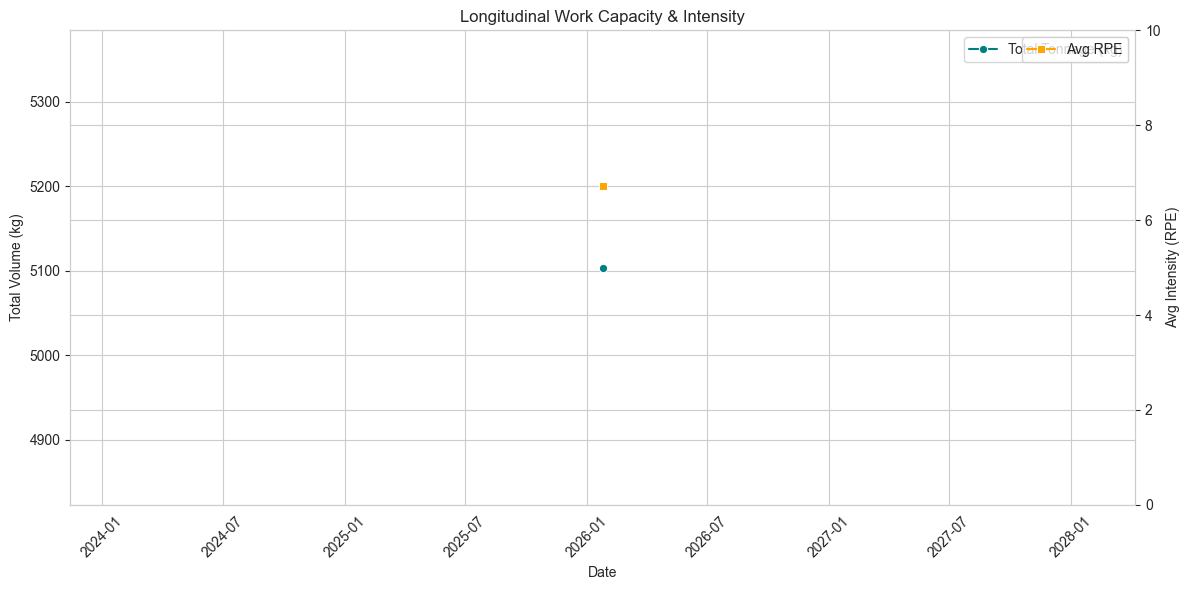

In [9]:
# Aggregate by Session
session_stats = df.groupby('Date').agg({
    'Volume_Load': 'sum',
    'Intensity_RPE': 'mean',
    'Movement': 'count'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot Volume Load
ax1 = sns.lineplot(data=session_stats, x='Date', y='Volume_Load', marker='o', label='Total Tonnage (kg)', color='teal')
plt.xticks(rotation=45)
ax1.set_ylabel("Total Volume (kg)")

# Plot RPE on secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=session_stats, x='Date', y='Intensity_RPE', marker='s', color='orange', label='Avg RPE', ax=ax2)
ax2.set_ylabel("Avg Intensity (RPE)")
ax2.set_ylim(0, 10)

plt.title("Longitudinal Work Capacity & Intensity")
plt.tight_layout()
plt.show()

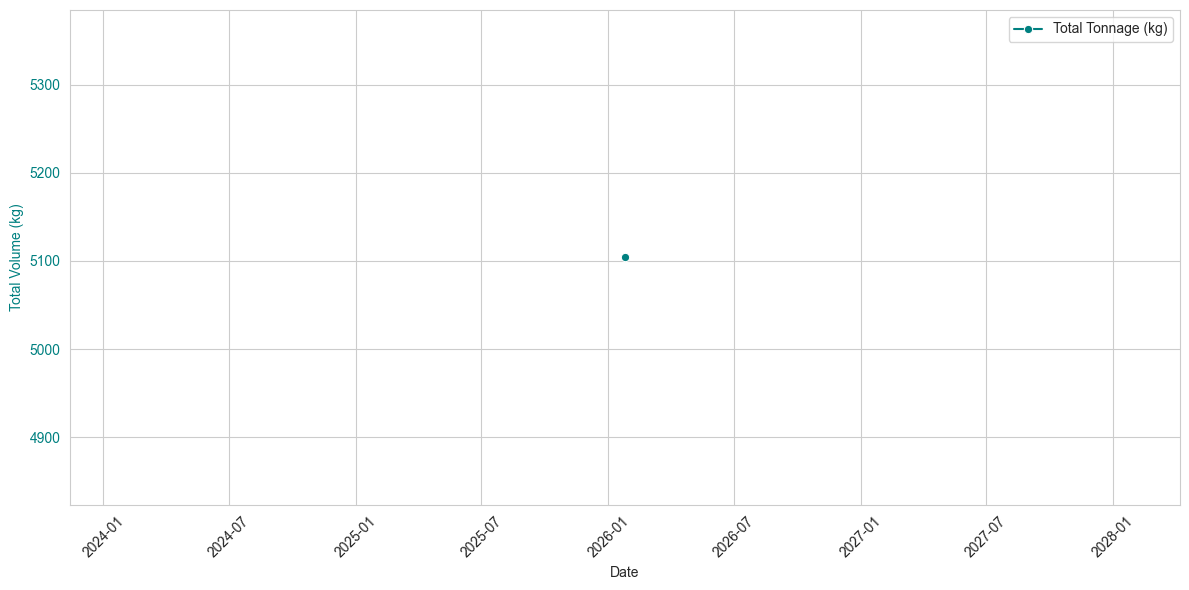

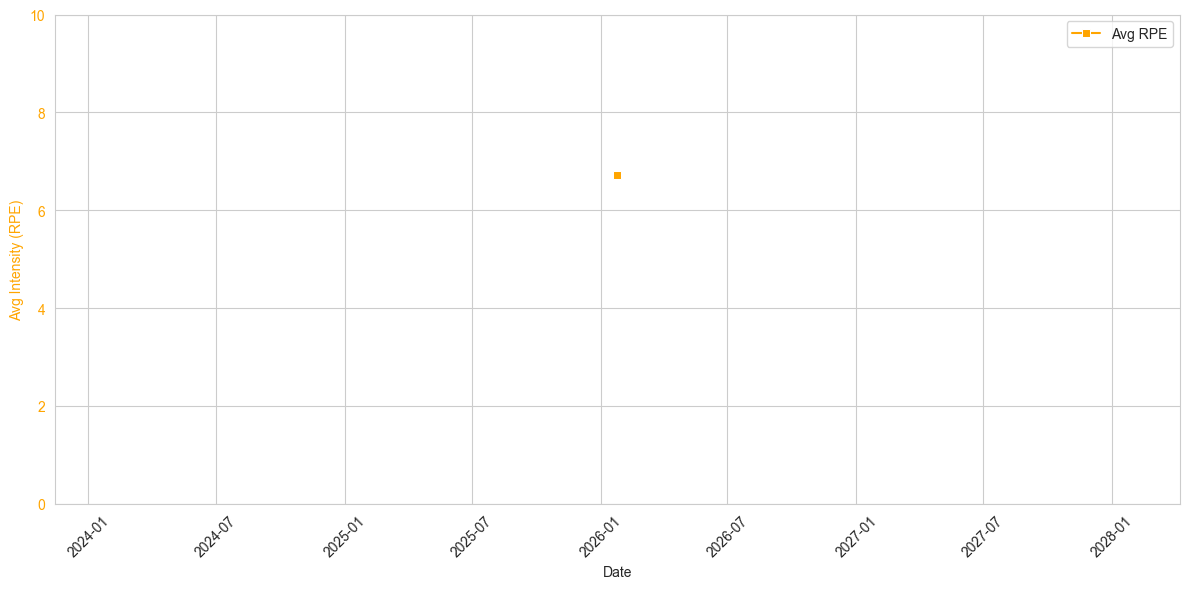

In [10]:
# Figure 1: Volume Load and Intensity Over Time
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=session_stats, x='Date', y='Volume_Load', marker='o', label='Total Tonnage (kg)', color='teal', ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Volume (kg)", color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Figure 2: Average RPE by Session
fig, ax2 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=session_stats, x='Date', y='Intensity_RPE', marker='s', color='orange', label='Avg RPE', ax=ax2)
ax2.set_xlabel("Date")
ax2.set_ylabel("Avg Intensity (RPE)", color='orange')
ax2.set_ylim(0, 10)
ax2.tick_params(axis='y', labelcolor='orange')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

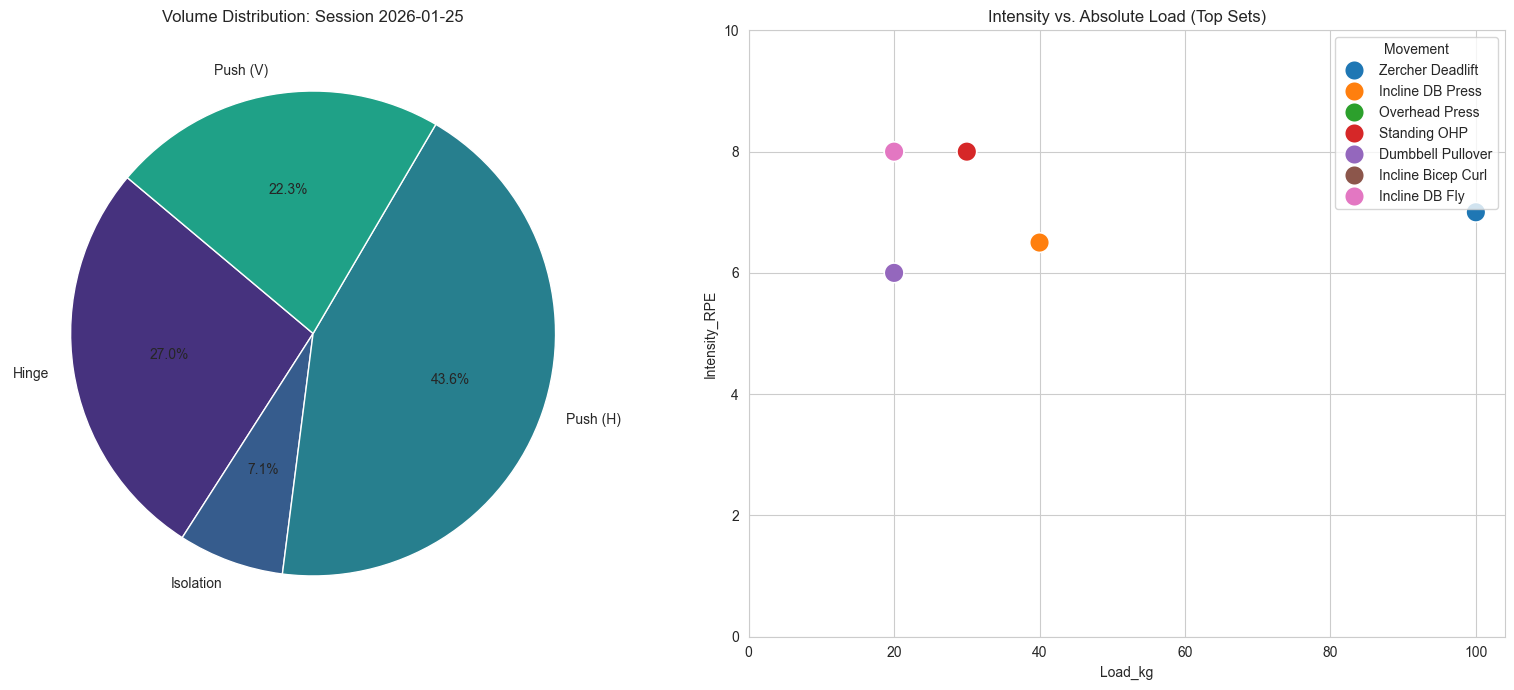

In [11]:
latest_date = df['Date'].max()
latest_session = df[df['Date'] == latest_date]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1. Volume Distribution by Family
family_dist = latest_session.groupby('Family')['Volume_Load'].sum()
ax1.pie(family_dist, labels=family_dist.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
ax1.set_title(f"Volume Distribution: Session {latest_date}")

# 2. Top Sets (Max Load vs RPE)
top_sets = latest_session.sort_values('Load_kg', ascending=False).drop_duplicates('Movement')
sns.scatterplot(data=top_sets, x='Load_kg', y='Intensity_RPE', hue='Movement', s=200, ax=ax2)
ax2.set_title("Intensity vs. Absolute Load (Top Sets)")
ax2.set_xlim(left=0)
ax2.set_ylim(0, 10)

plt.tight_layout()
plt.show()

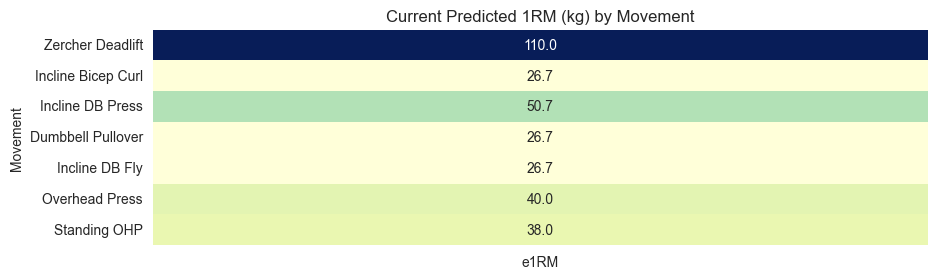

In [12]:
# Cell: Strength Matrix / Current Maxes
def get_current_maxes(df):
    # Sort by date and e1RM to get the best recent performance
    idx = df.groupby('Movement')['e1RM'].idxmax()
    maxes = df.loc[idx, ['Movement', 'Family', 'e1RM', 'Date']]
    maxes = maxes.sort_values(by=['Family', 'e1RM'], ascending=[True, False])
    
    # Create a styled table/heatmap
    plt.figure(figsize=(10, len(maxes) * 0.4))
    sns.heatmap(maxes[['e1RM']].set_index(maxes['Movement']), 
                annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
    plt.title("Current Predicted 1RM (kg) by Movement")
    plt.show()

get_current_maxes(df)

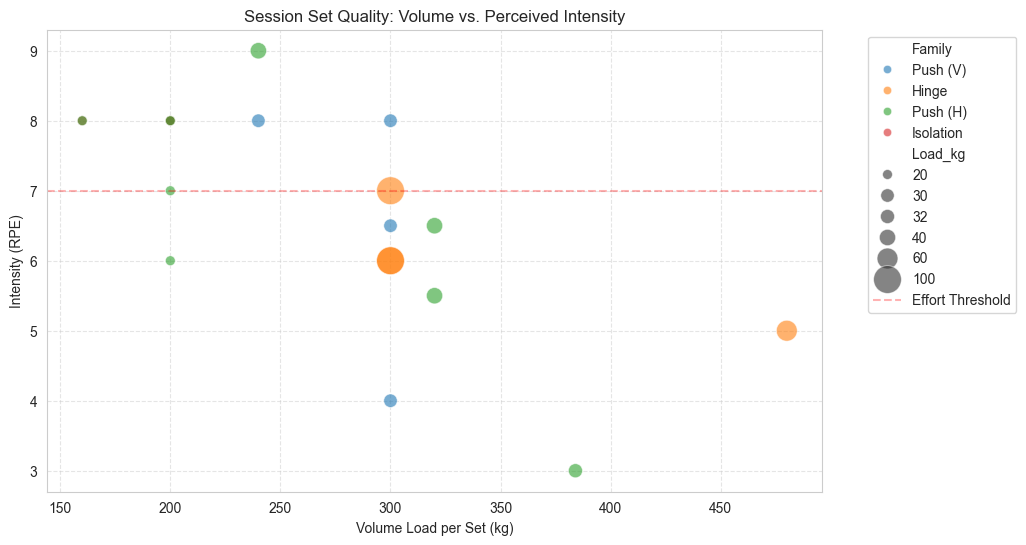

In [13]:
# Cell: Volume vs Intensity Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Volume_Load', y='Intensity_RPE', 
                hue='Family', size='Load_kg', sizes=(50, 400), alpha=0.6)

plt.axhline(y=7, color='r', linestyle='--', alpha=0.3, label='Effort Threshold')
plt.title("Session Set Quality: Volume vs. Perceived Intensity")
plt.xlabel("Volume Load per Set (kg)")
plt.ylabel("Intensity (RPE)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

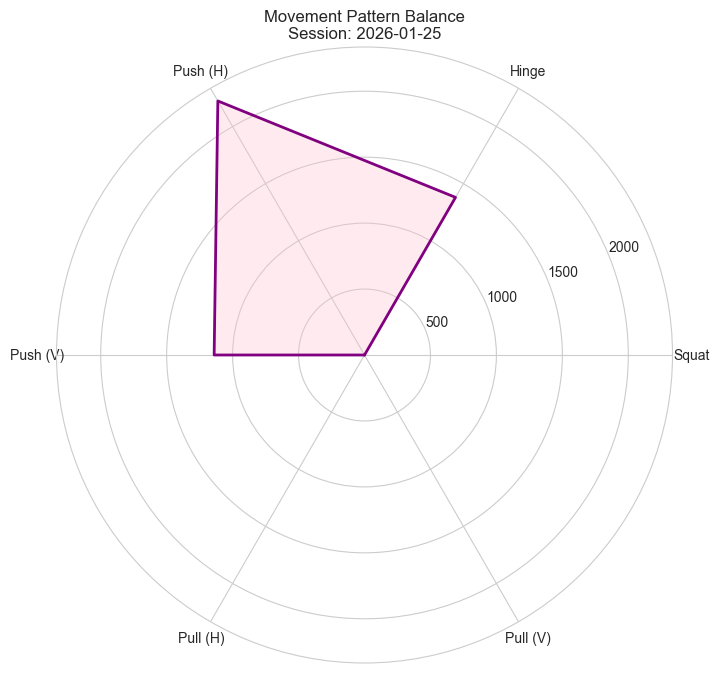

In [14]:
def plot_session_balance(session_df):
    # Define the 4-6 primary patterns we want to see
    patterns = ['Squat', 'Hinge', 'Push (H)', 'Push (V)', 'Pull (H)', 'Pull (V)']
    
    # Calculate volume per family for this session
    stats = session_df.groupby('Family')['Volume_Load'].sum().reindex(patterns, fill_value=0)
    
    values = stats.values.flatten().tolist()
    values += values[:1] # Close the polygon
    angles = [n / float(len(patterns)) * 2 * np.pi for n in range(len(patterns))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='purple', linewidth=2)
    ax.fill(angles, values, color='pink', alpha=0.3)
    
    plt.xticks(angles[:-1], patterns)
    plt.title(f"Movement Pattern Balance\nSession: {session_df['Date'].iloc[0]}")
    plt.show()

# To use:
plot_session_balance(df[df['Date'] == latest_date])

In [15]:
def display_strength_matrix(excel_path="../data/workout_log.xlsx"):
    df = pd.read_excel(excel_path)
    # Calculate e1RM
    df['e1RM'] = df['Load_kg'] * (1 + df['Reps'] / 30)
    
    # Get the max e1RM per Movement
    idx = df.groupby('Movement')['e1RM'].idxmax()
    matrix = df.loc[idx, ['Movement', 'e1RM', 'Timestamp']]
    
    # Stylize for a clear snapshot
    print("--- CURRENT PREDICTED 1RM SNAPSHOT ---")
    return matrix.sort_values(by='e1RM', ascending=False)#.style.background_gradient(cmap='Blues')
display_strength_matrix()

--- CURRENT PREDICTED 1RM SNAPSHOT ---


,Movement,e1RM,Timestamp
5,Zercher Deadlift,110.000000,2026-01-25 10:00:00
9,Incline DB Press,50.666667,2026-01-25 10:00:00
0,Overhead Press,40.000000,2026-01-25 10:00:00
3,Standing OHP,38.000000,2026-01-25 10:00:00
16,Incline DB Fly,26.666667,2026-01-25 10:00:00
12,Dumbbell Pullover,26.666667,2026-01-25 10:00:00
15,Incline Bicep Curl,26.666667,2026-01-25 10:00:00


In [16]:
import numpy as np

# Aggregate ALL data
total_family_vol = df.groupby('Family')['Volume_Load'].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'ax2': dict(polar=True)})
plt.delaxes(ax2) # Remove standard axes to replace with polar
ax2 = fig.add_subplot(122, polar=True)

# 1. Pie Chart: Total Volume Distribution
ax1.pie(total_family_vol, labels=total_family_vol.index, autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette("magma", len(total_family_vol)))
ax1.set_title("Longitudinal Volume Distribution (All Time)")

# 2. Radar Chart: Movement Pattern Balance
patterns = ['Squat', 'Hinge', 'Push (H)', 'Push (V)', 'Pull (H)', 'Pull (V)']
# Ensure all patterns exist even if volume is 0
stats = total_family_vol.reindex(patterns, fill_value=0)

values = stats.values.flatten().tolist()
values += values[:1]
angles = [n / float(len(patterns)) * 2 * np.pi for n in range(len(patterns))]
angles += angles[:1]

ax2.plot(angles, values, color='#8a2be2', linewidth=2) # Gothic-alternative purple
ax2.fill(angles, values, color='#da70d6', alpha=0.3)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(patterns)
ax2.set_title("Total Pattern Balance (Net Gain)")

plt.tight_layout()
plt.show()

AttributeError: Axes.set() got an unexpected keyword argument 'ax2'

<Figure size 1600x700 with 0 Axes>

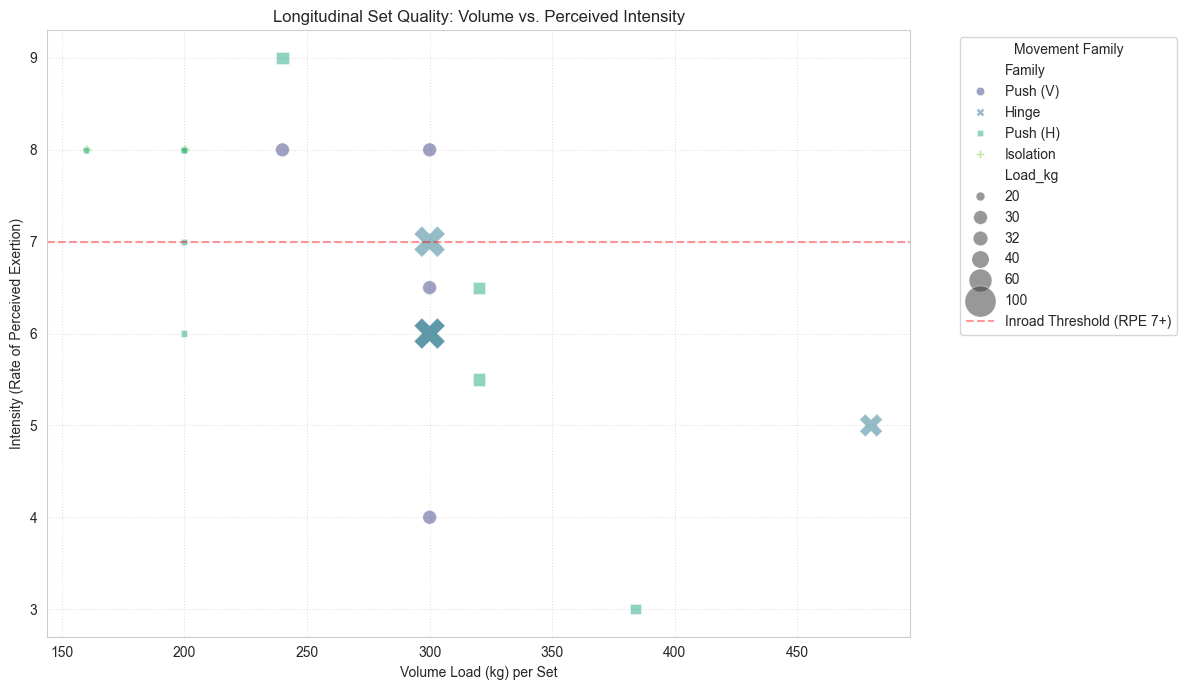

In [18]:
# Cell: Longitudinal Intensity vs Volume
plt.figure(figsize=(12, 7))

# We use 'df' instead of 'latest_session' to see the whole history
sns.scatterplot(data=df, x='Volume_Load', y='Intensity_RPE', 
                hue='Family', style='Family', size='Load_kg', 
                sizes=(40, 500), alpha=0.5, palette='viridis')

# Physics-style threshold line: Efforts above RPE 7 are "Effective Reps"
plt.axhline(y=7, color='red', linestyle='--', alpha=0.4, label='Inroad Threshold (RPE 7+)')

plt.title("Longitudinal Set Quality: Volume vs. Perceived Intensity")
plt.xlabel("Volume Load (kg) per Set")
plt.ylabel("Intensity (Rate of Perceived Exertion)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Movement Family")
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

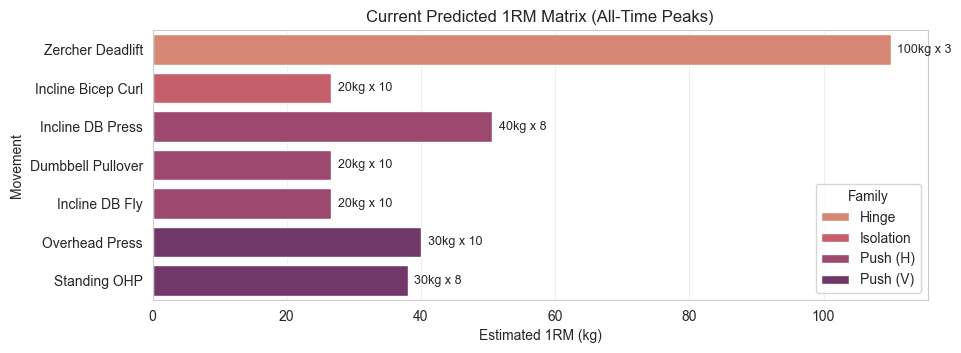

In [19]:
# Cell: The Strength Matrix (Max Predicted 1RM)
def plot_strength_matrix(df):
    # Get the best e1RM ever recorded for each movement
    max_perf = df.sort_values('e1RM', ascending=False).drop_duplicates('Movement')
    matrix_data = max_perf[['Movement', 'Family', 'e1RM', 'Load_kg', 'Reps']].sort_values('Family')
    
    # Create a pivot-style display
    plt.figure(figsize=(10, len(matrix_data) * 0.5))
    sns.barplot(data=matrix_data, x='e1RM', y='Movement', hue='Family', dodge=False, palette='flare')
    
    # Annotate with the specific Load x Reps that produced that 1RM
    for i, row in enumerate(matrix_data.itertuples()):
        plt.text(row.e1RM + 1, i, f"{row.Load_kg}kg x {row.Reps}", va='center', fontsize=9)

    plt.title("Current Predicted 1RM Matrix (All-Time Peaks)")
    plt.xlabel("Estimated 1RM (kg)")
    plt.grid(axis='x', alpha=0.3)
    plt.show()

plot_strength_matrix(df)

C:\Users\jones\AppData\Local\Temp\ipykernel_45840\491177895.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=m_df, y='Goal', x='Current', palette='viridis')


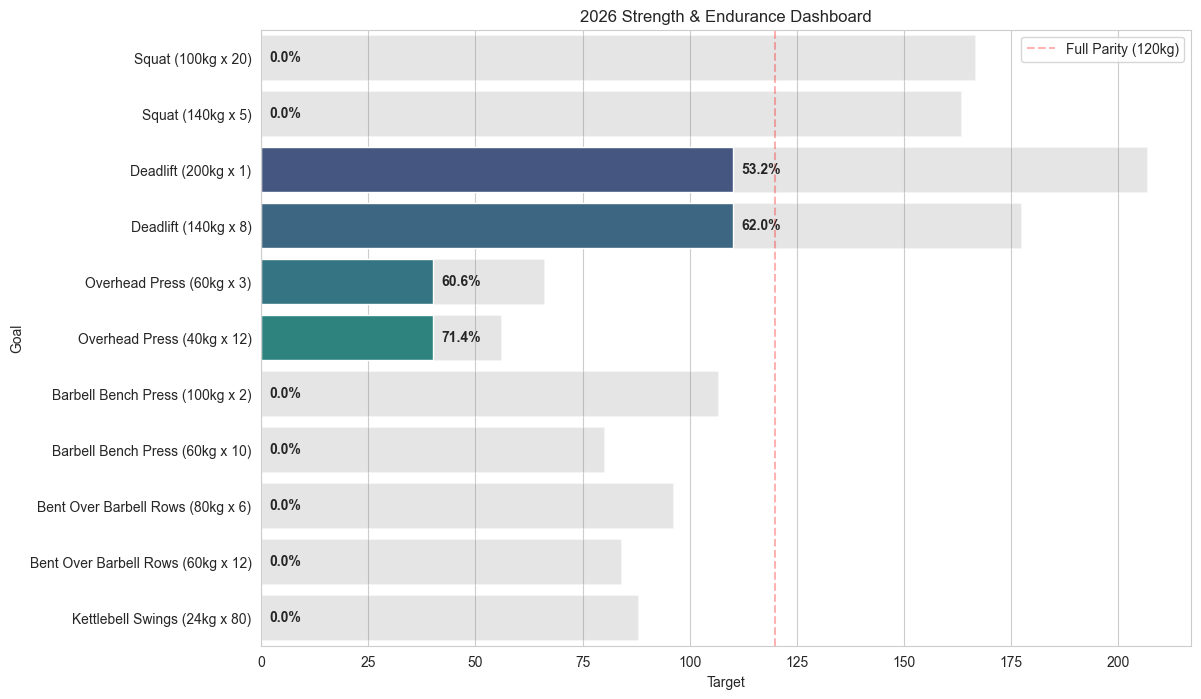

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime

# 1. THE DATA SYNC ENGINE
def sync_gym_logs(data_dir="../data/", excel_name="workout_log.xlsx"):
    excel_path = os.path.join(data_dir, excel_name)
    processed_ts = set()
    
    # Check if data directory exists to avoid FileNotFoundError
    if not os.path.exists(data_dir):
        print(f"Warning: Directory {data_dir} not found. Creating it...")
        os.makedirs(data_dir)

    if os.path.exists(excel_path):
        df_existing = pd.read_excel(excel_path)
        processed_ts = set(df_existing['Timestamp'].astype(str).unique())
    else:
        df_existing = pd.DataFrame()

    new_data = []
    # Loop through JSON files
    for file in [f for f in os.listdir(data_dir) if f.endswith('.json')]:
        with open(os.path.join(data_dir, file), 'r') as f:
            session = json.load(f)
            if session and str(session[0].get("Timestamp")) not in processed_ts:
                new_data.append(session)
    
    if new_data:
        # Flatten the list of sessions and calculate e1RM
        flat_new_data = [item for sublist in new_data for item in sublist]
        df_new = pd.DataFrame(flat_new_data)
        
        # Calculate e1RM on the fly during sync
        df_new['e1RM'] = df_new['Load_kg'] * (1 + df_new['Reps'] / 30)
        
        df_final = pd.concat([df_existing, df_new], ignore_index=True)
        df_final.sort_values("Timestamp").to_excel(excel_path, index=False)
        print(f"Sync complete: {len(df_new)} new sets added.")
        return df_final
    
    # If no new data, still ensure the existing df has e1RM for the plot
    if not df_existing.empty and 'e1RM' not in df_existing.columns:
        df_existing['e1RM'] = df_existing['Load_kg'] * (1 + df_existing['Reps'] / 30)
        
    return df_existing

# 2. THE MILESTONE ENGINE
def plot_advanced_milestones(df):
    if df is None or df.empty:
        print("No data available to plot.")
        return

    current_maxes = df.groupby('Movement')['e1RM'].max()
    
    milestones = {
        'Squat': [(100, 20), (140, 5)],
        'Deadlift': [(200, 1), (140, 8)],
        'Overhead Press': [(60, 3), (40, 12)],
        'Barbell Bench Press': [(100, 2), (60, 10)],
        'Bent Over Barbell Rows': [(80, 6), (60, 12)],
        'Kettlebell Swings': [(24, 80)]
    }
    
    plot_data = []
    for move, targets in milestones.items():
        family_moves = [m for m in current_maxes.index if move.lower() in m.lower()]
        family_best = current_maxes[family_moves].max() if family_moves else 0
            
        for w, r in targets:
            target_e1rm = w * (1 + r/30)
            plot_data.append({'Goal': f"{move} ({w}kg x {r})", 'Current': family_best, 'Target': target_e1rm})

    m_df = pd.DataFrame(plot_data)
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(data=m_df, y='Goal', x='Target', color='grey', alpha=0.2)
    sns.barplot(data=m_df, y='Goal', x='Current', palette='viridis')
    
    plt.axvline(x=120, color='red', linestyle='--', alpha=0.3, label='Full Parity (120kg)')
    
    for i, row in m_df.iterrows():
        pct = (row['Current'] / row['Target']) * 100 if row['Target'] > 0 else 0
        plt.text(row['Current'] + 2, i, f"{pct:.1f}%", va='center', fontweight='bold')

    plt.title("2026 Strength & Endurance Dashboard")
    plt.legend()
    plt.show()

# 3. RUN ANALYSIS
# Note: Ensure your data directory exists relative to this notebook's location
df = sync_gym_logs(data_dir="../data/") 
plot_advanced_milestones(df)

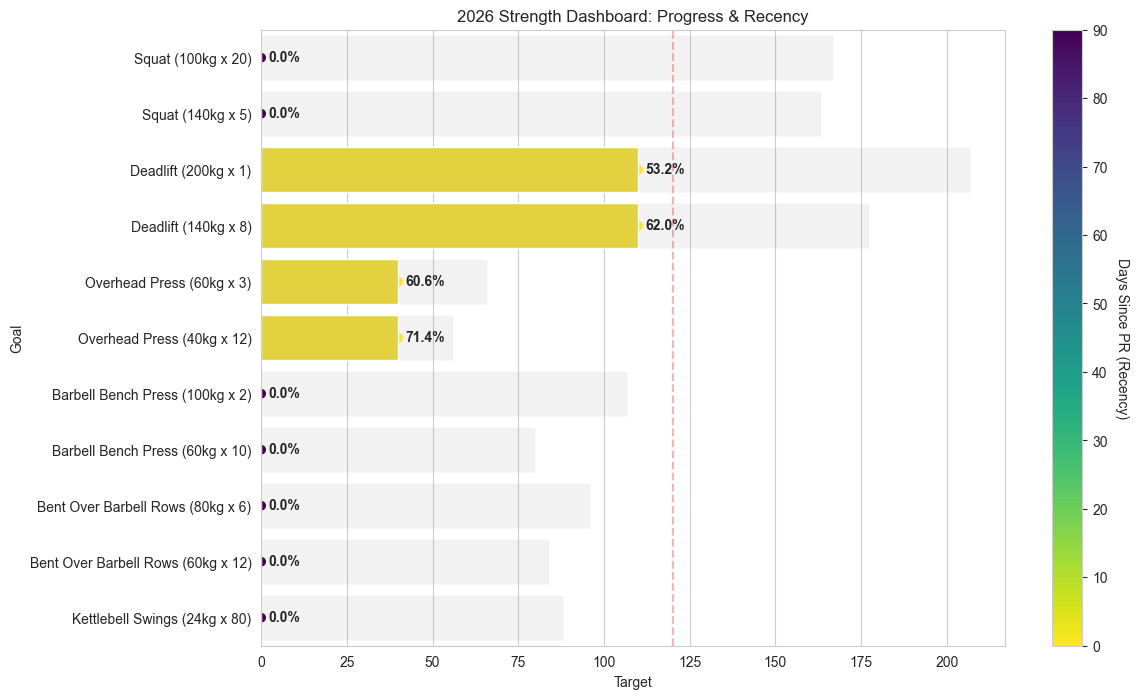

In [21]:
def plot_advanced_milestones_with_recency(df):
    if df is None or df.empty:
        print("No data available.")
        return

    # Ensure Timestamp is datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['e1RM'] = df['Load_kg'] * (1 + df['Reps'] / 30)
    
    # Milestone Dictionary
    milestones = {
        'Squat': [(100, 20), (140, 5)],
        'Deadlift': [(200, 1), (140, 8)],
        'Overhead Press': [(60, 3), (40, 12)],
        'Barbell Bench Press': [(100, 2), (60, 10)],
        'Bent Over Barbell Rows': [(80, 6), (60, 12)],
        'Kettlebell Swings': [(24, 80)]
    }
    
    plot_data = []
    today = pd.Timestamp(datetime.now())

    for move, targets in milestones.items():
        # Filter for family and find the best set
        family_df = df[df['Movement'].str.contains(move, case=False, na=False)]
        
        if not family_df.empty:
            best_row = family_df.loc[family_df['e1RM'].idxmax()]
            family_best = best_row['e1RM']
            last_date = best_row['Timestamp']
            days_ago = (today - last_date).days
        else:
            family_best, days_ago = 0, 365 # Default to 'stale' if never hit

        for w, r in targets:
            target_e1rm = w * (1 + r/30)
            plot_data.append({
                'Goal': f"{move} ({w}kg x {r})", 
                'Current': family_best, 
                'Target': target_e1rm,
                'Days Ago': days_ago
            })

    m_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 8))
    # Background Target Bars
    sns.barplot(data=m_df, y='Goal', x='Target', color='grey', alpha=0.1)
    
    # Foreground Progress Bars colored by 'Days Ago'
    # Low days = Bright Purple/Teal; High days = Greyish
    scatter = plt.scatter(m_df['Current'], m_df['Goal'], c=m_df['Days Ago'], cmap='viridis_r')
    bar_plot = sns.barplot(data=m_df, y='Goal', x='Current', hue='Days Ago', palette='viridis_r', dodge=False)
    
    # Cleanup legend and add colorbar
    plt.gca().get_legend().remove()
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(0, 90)), ax=plt.gca())
    cbar.set_label('Days Since PR (Recency)', rotation=270, labelpad=15)

    plt.axvline(x=120, color='red', linestyle='--', alpha=0.3, label='Full Parity (120kg)')
    
    for i, row in m_df.iterrows():
        pct = (row['Current'] / row['Target']) * 100 if row['Target'] > 0 else 0
        plt.text(row['Current'] + 2, i, f"{pct:.1f}%", va='center', fontweight='bold')

    plt.title("2026 Strength Dashboard: Progress & Recency")
    plt.show()

# Run the updated plot
plot_advanced_milestones_with_recency(df)

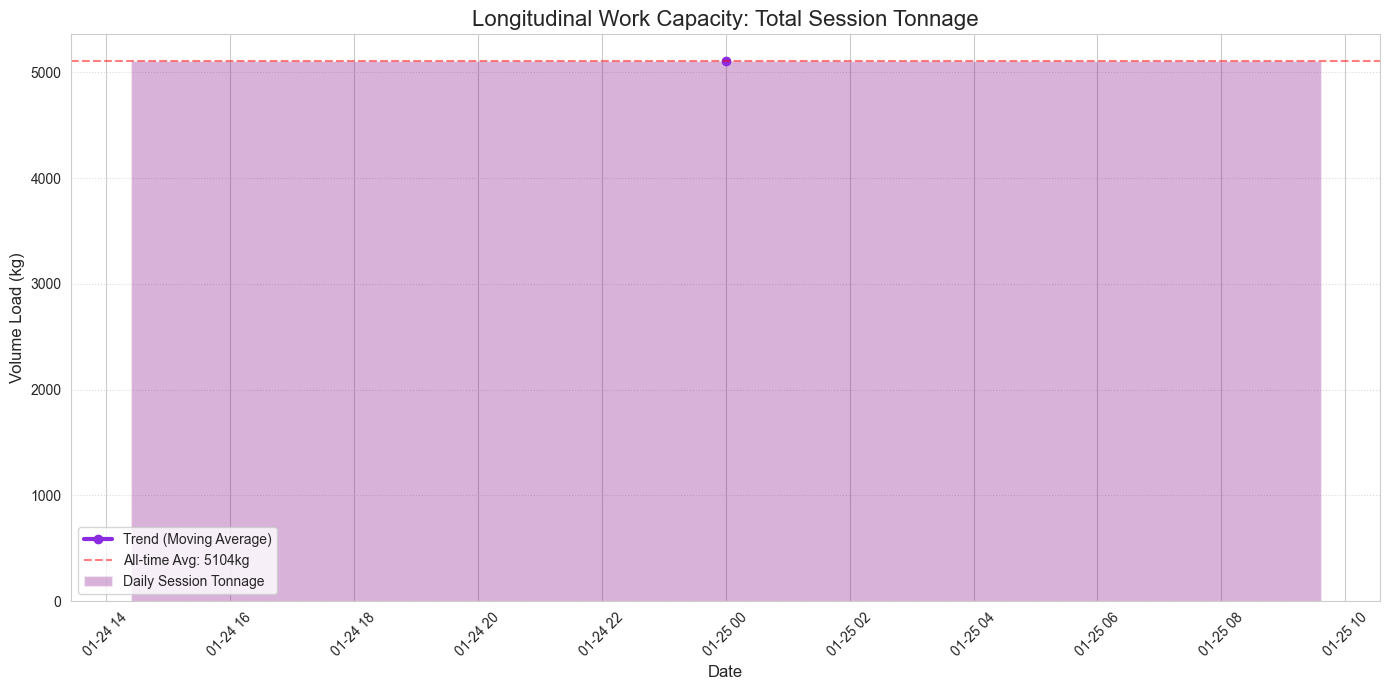

In [22]:
def plot_tonnage_timeseries(df):
    if df is None or df.empty:
        print("No data available to plot tonnage.")
        return

    # 1. Aggregate Volume by Date/Timestamp
    # Using 'Timestamp' ensures multiple sessions in one day are distinct if needed
    df['Date'] = pd.to_datetime(df['Timestamp']).dt.date
    session_tonnage = df.groupby('Date')['Volume_Load'].sum().reset_index()
    session_tonnage = session_tonnage.sort_values('Date')

    # 2. Calculate Rolling Average for Trend Analysis
    session_tonnage['7_Day_MA'] = session_tonnage['Volume_Load'].rolling(window=3, min_periods=1).mean()

    # 3. Plotting
    plt.figure(figsize=(14, 7))
    
    # Bar chart for discrete session totals
    plt.bar(session_tonnage['Date'], session_tonnage['Volume_Load'], 
            alpha=0.3, color='purple', label='Daily Session Tonnage')
    
    # Line chart for the trend
    plt.plot(session_tonnage['Date'], session_tonnage['7_Day_MA'], 
             color='#8a2be2', linewidth=3, marker='o', label='Trend (Moving Average)')

    # Add 2026 Milestone lines if relevant (e.g., average tonnage per session)
    avg_tonnage = session_tonnage['Volume_Load'].mean()
    plt.axhline(y=avg_tonnage, color='red', linestyle='--', alpha=0.5, label=f'All-time Avg: {avg_tonnage:.0f}kg')

    plt.title("Longitudinal Work Capacity: Total Session Tonnage", fontsize=16)
    plt.ylabel("Volume Load (kg)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_tonnage_timeseries(df)

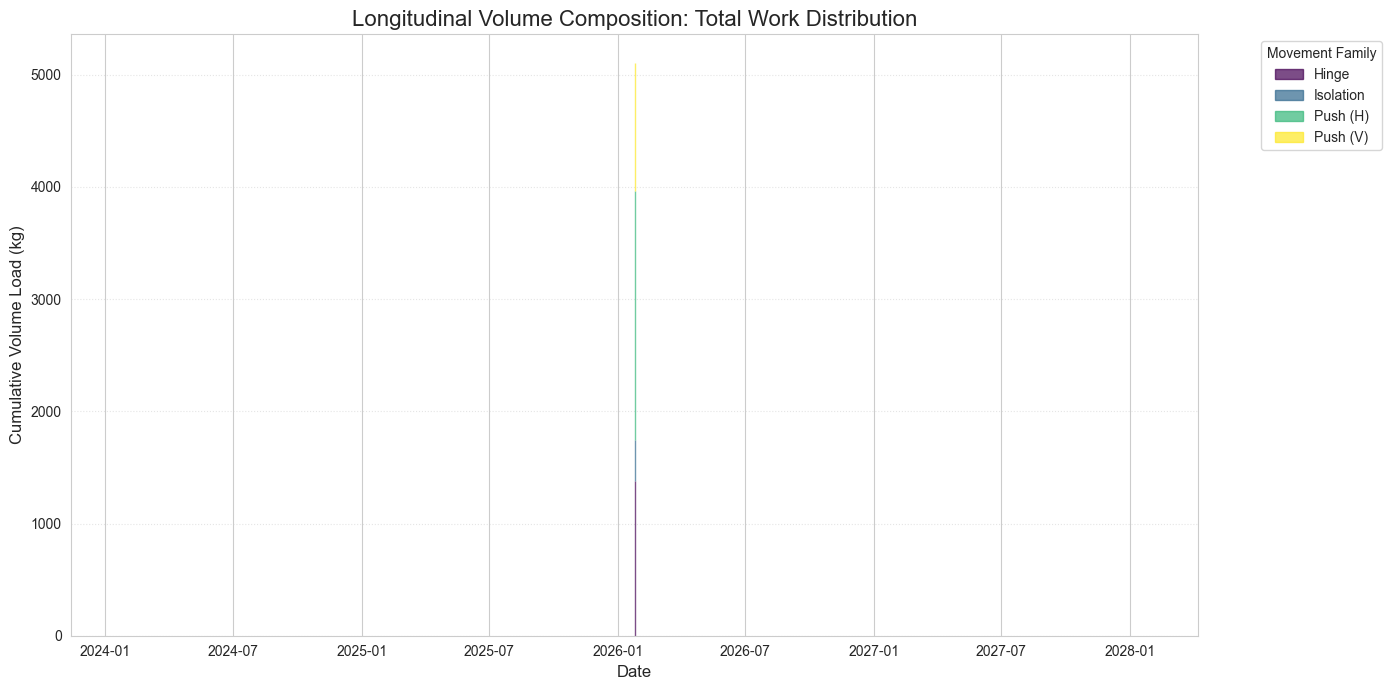

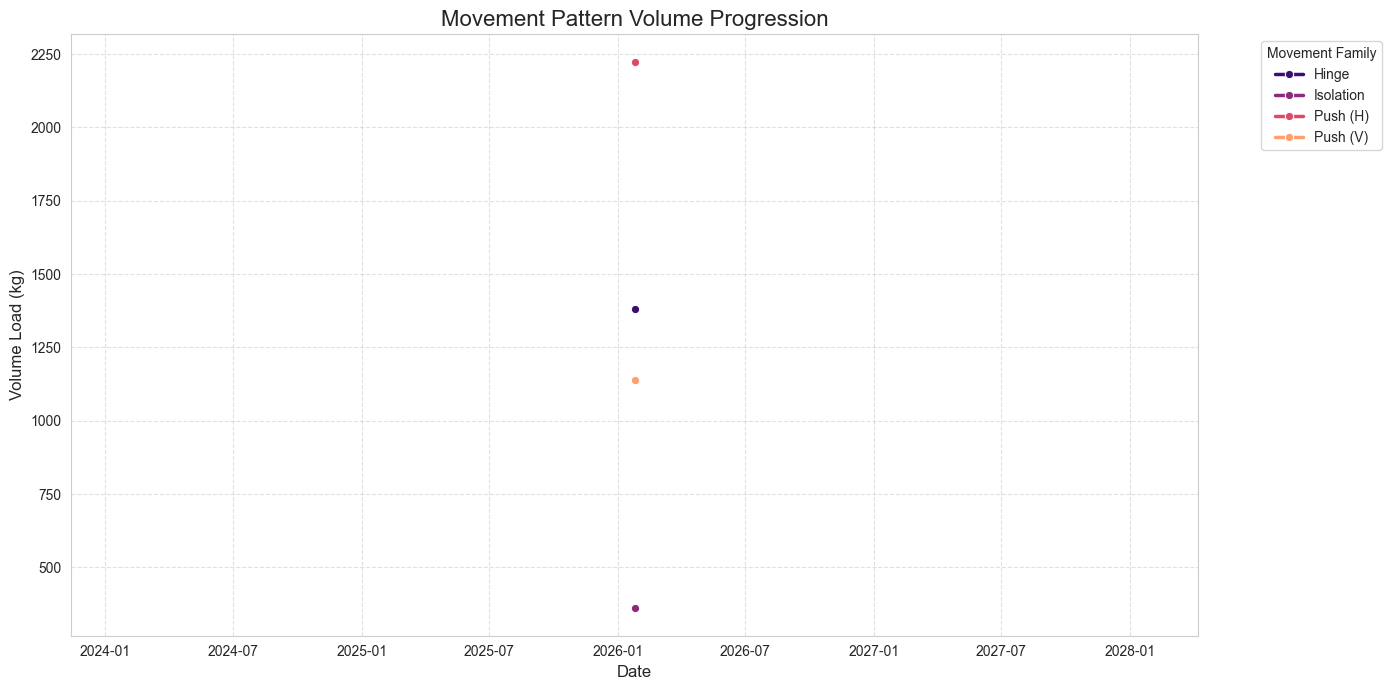

In [25]:
# 1. Ensure the Family Mapping and Tonnage calculations are present
def prepare_df_for_plots(df):
    df = df.copy()
    
    # Standardize column names (Defensive programming)
    df.columns = df.columns.str.strip()
    
    # Calculate Volume_Load if it's missing (Volume = Mass x Reps)
    if 'Volume_Load' not in df.columns:
        df['Volume_Load'] = df['Load_kg'] * df['Reps']
        
    # Apply your Family Map
    df['Family'] = df['Movement'].map(FAMILY_MAP).fillna("Other")
    
    # Ensure Timestamp is datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = df['Timestamp'].dt.date
    
    return df

# 2. Execution logic
df = pd.read_excel("../data/workout_log.xlsx")
df = prepare_df_for_plots(df)

# Now call your functions
plot_volume_composition(df)
plot_pattern_progression(df)

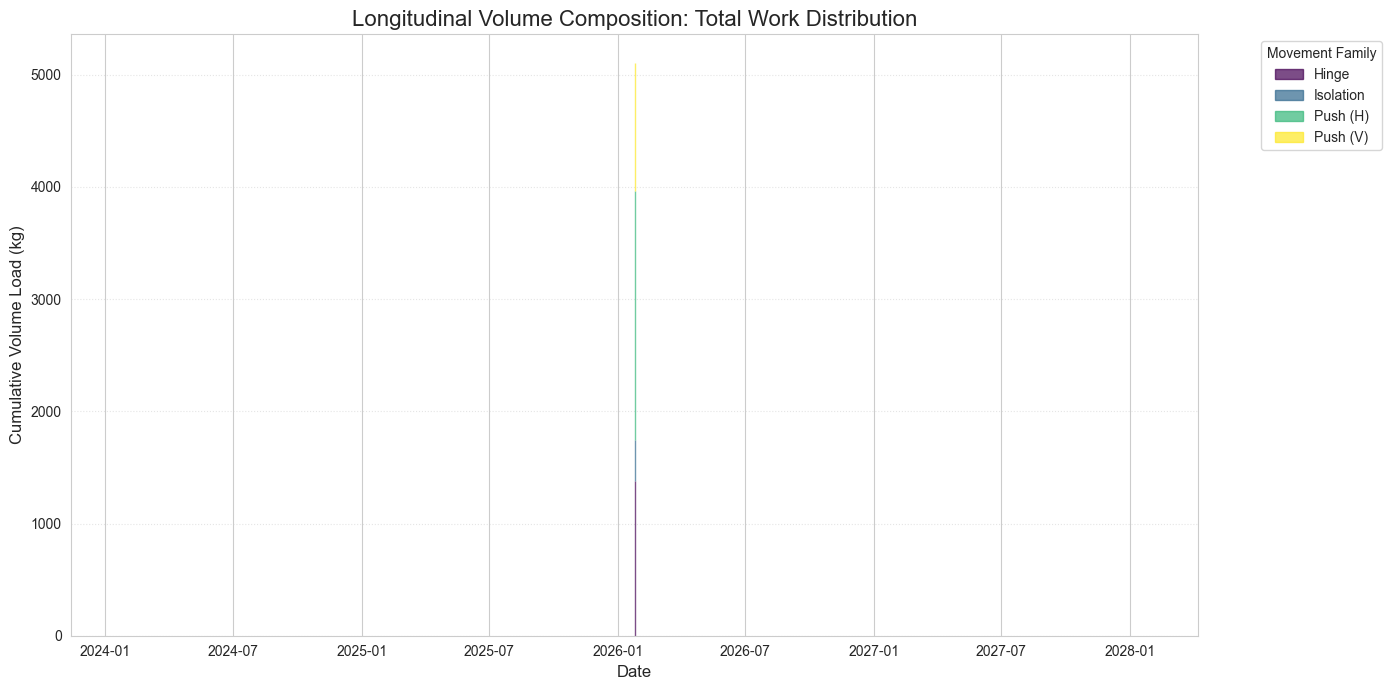

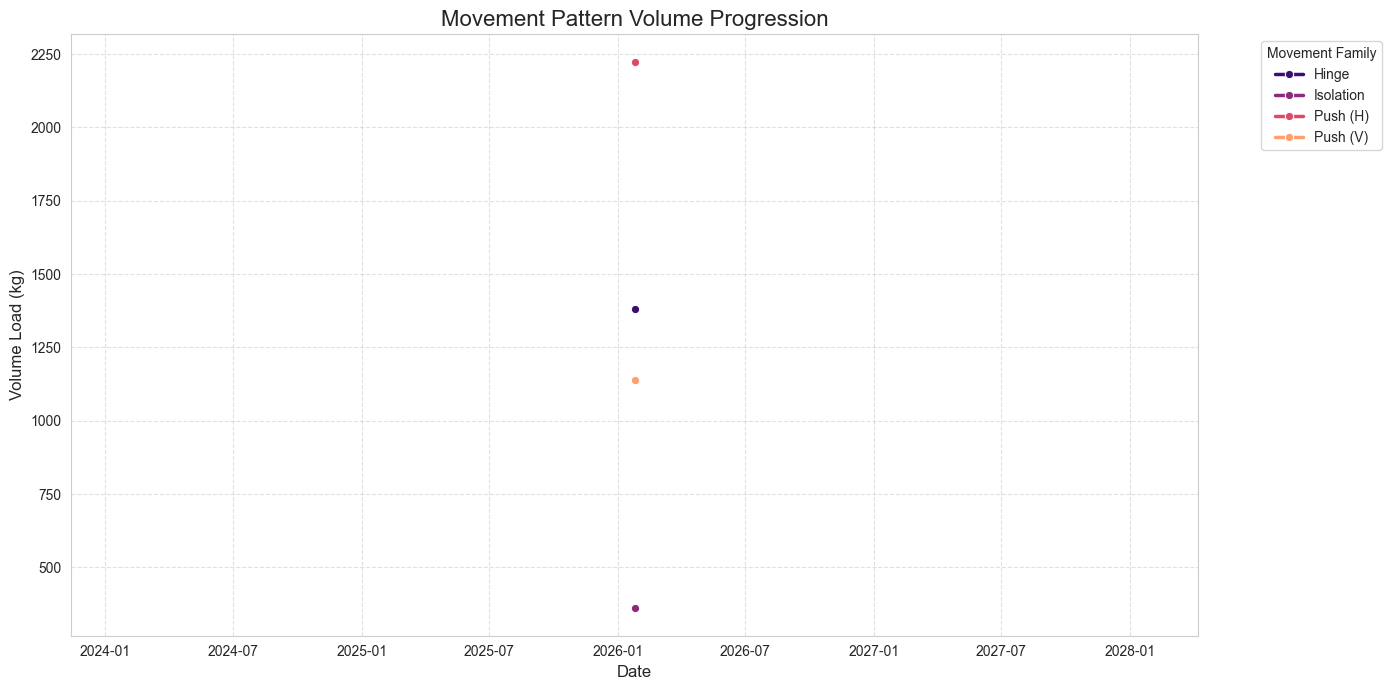

In [26]:
def plot_volume_composition(df):
    """
    Stacked Area Chart: Visualizes the total 'Work' (Tonnage) 
    and how the composition of that work changes over time.
    """
    if df.empty: return
    
    # Pre-processing: Extract date and pivot
    df_plot = df.copy()
    df_plot['Date'] = pd.to_datetime(df_plot['Timestamp']).dt.date
    # Pivot to get Dates as index and Families as columns
    pivot_df = df_plot.pivot_table(index='Date', columns='Family', 
                                  values='Volume_Load', aggfunc='sum').fillna(0)
    
    plt.figure(figsize=(14, 7))
    pivot_df.plot(kind='area', stacked=True, ax=plt.gca(), colormap='viridis', alpha=0.7)
    
    plt.title("Longitudinal Volume Composition: Total Work Distribution", fontsize=16)
    plt.ylabel("Cumulative Volume Load (kg)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(title="Movement Family", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_pattern_progression(df):
    """
    Multi-line Chart: Tracks the independent progression of each 
    movement family to identify adaptive plateaus.
    """
    if df.empty: return

    df_plot = df.copy()
    df_plot['Date'] = pd.to_datetime(df_plot['Timestamp']).dt.date
    # Aggregate by date and family to handle multiple movements per family in one session
    agg_df = df_plot.groupby(['Date', 'Family'])['Volume_Load'].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=agg_df, x='Date', y='Volume_Load', hue='Family', 
                 marker='o', linewidth=2.5, palette='magma')
    
    plt.title("Movement Pattern Volume Progression", fontsize=16)
    plt.ylabel("Volume Load (kg)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(title="Movement Family", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# To execute:
plot_volume_composition(df)
plot_pattern_progression(df)